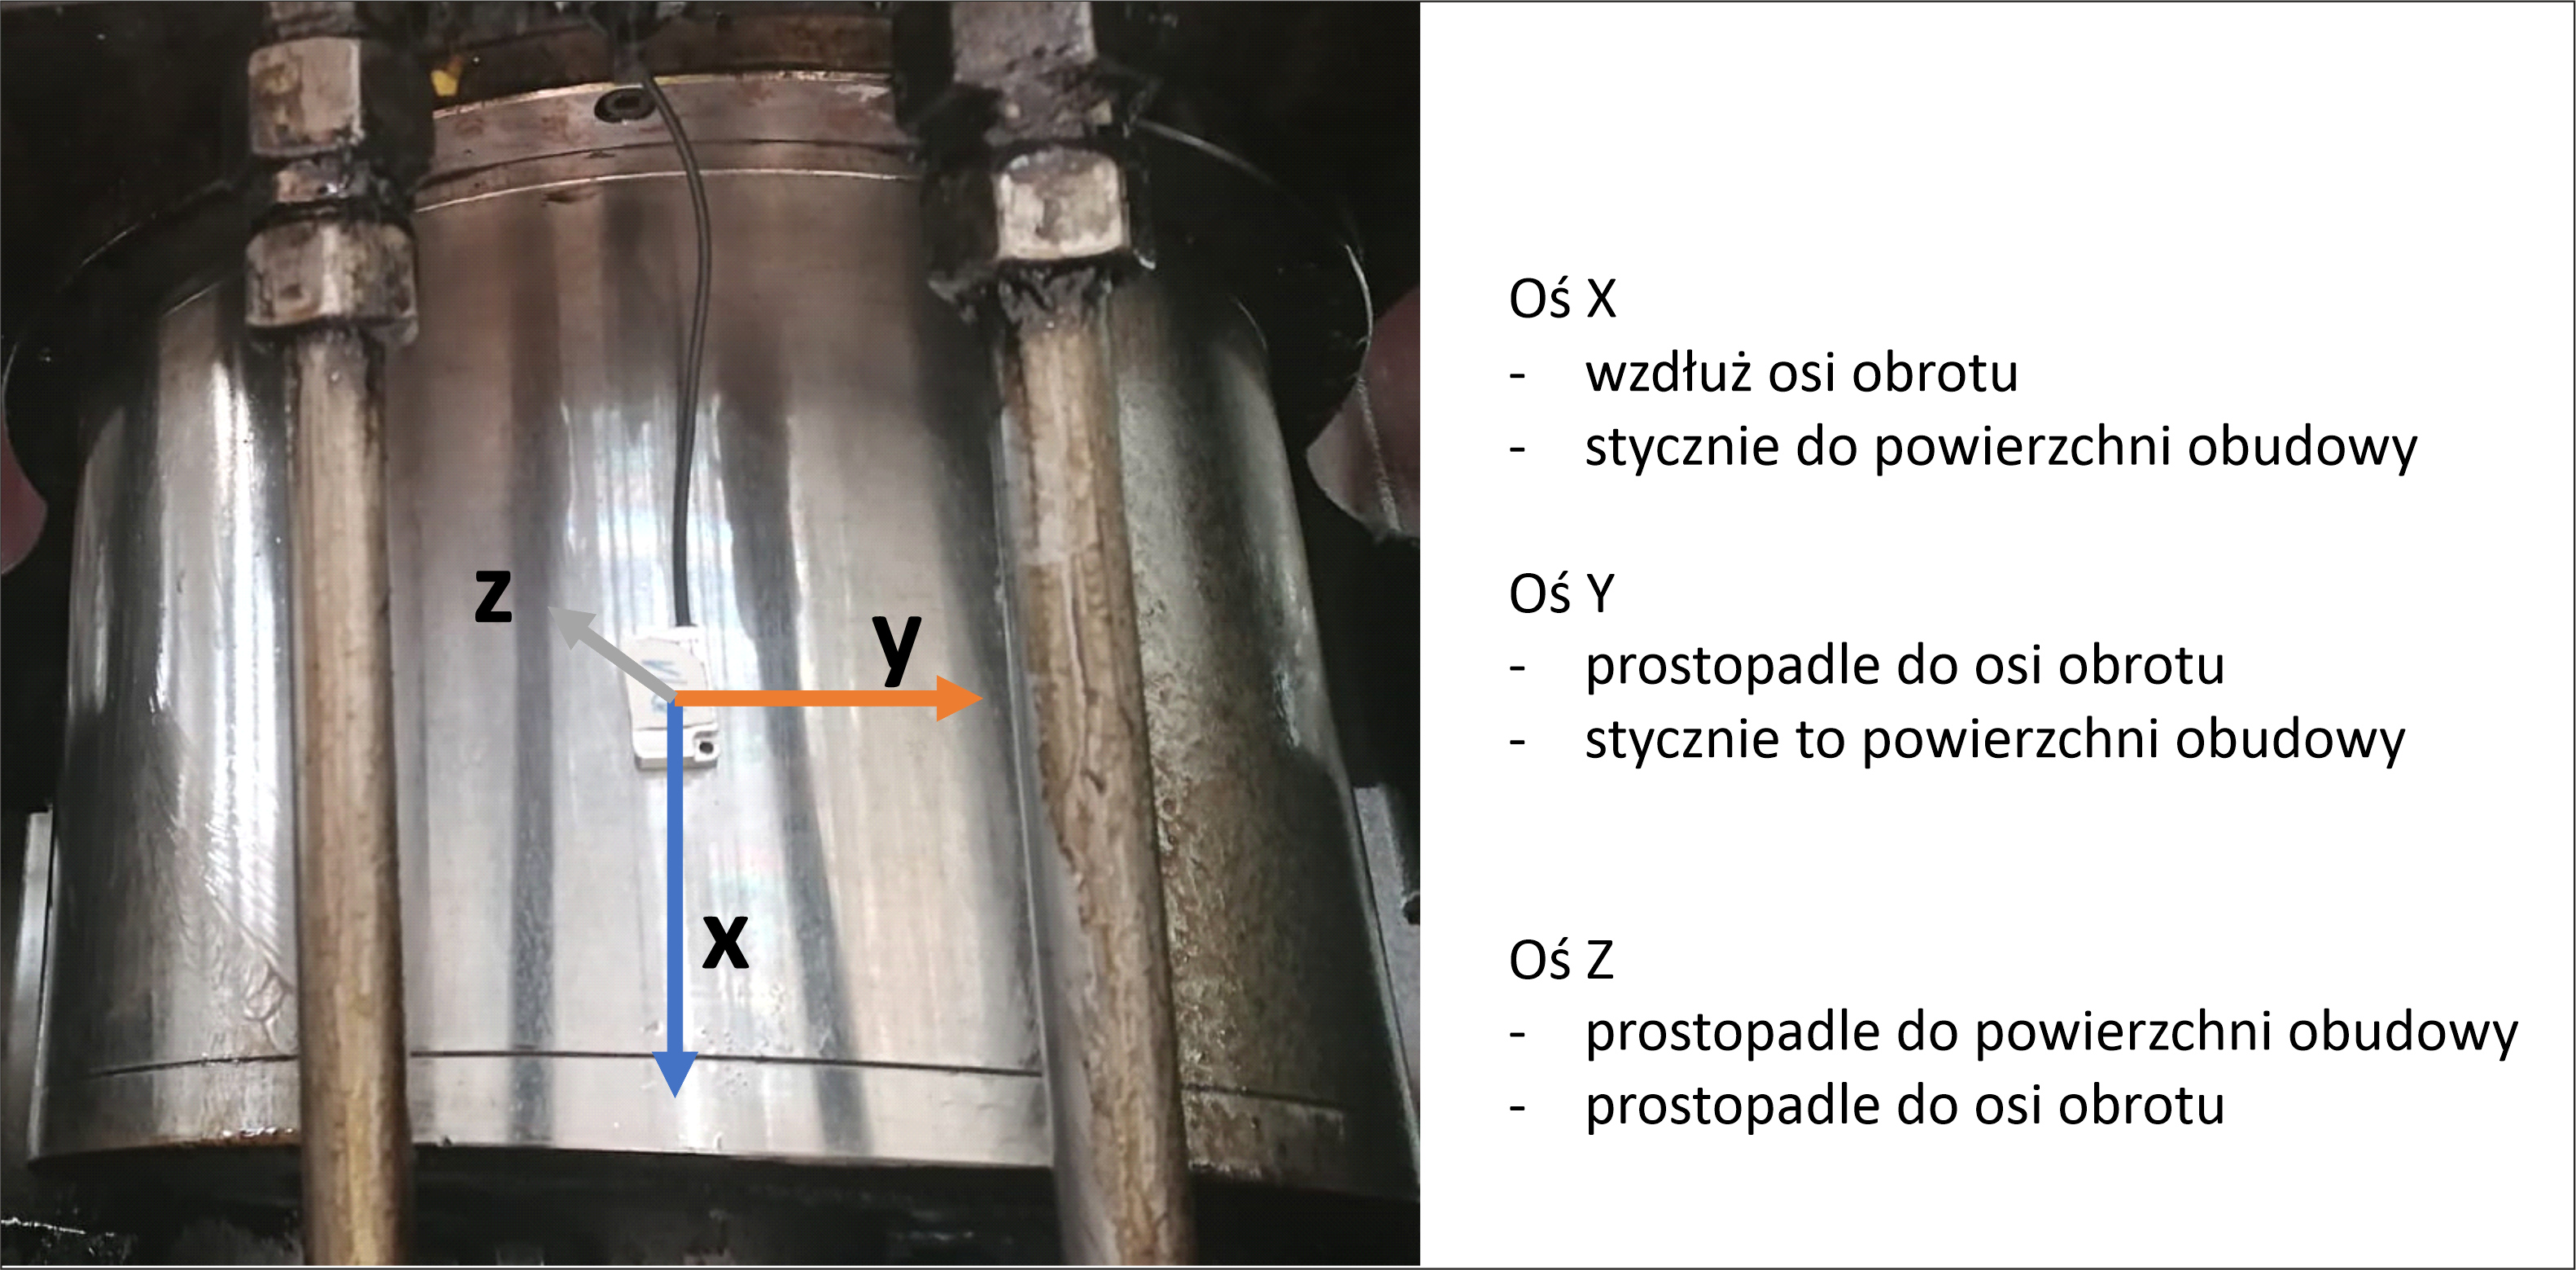

In [100]:
from IPython.display import Image
Image(filename='Winkelmann.png')

Winkelmann data: 2 sensor, each mounted to separate device; each sensor measures 3 components.

# Time Series Analysis: Data exploration and Anomaly Detection

The first step around any data related challenge is to start by exploring the data itself. This could be by looking at, for example, the distributions of certain variables or looking at potential correlations between variables.
Data have high number of dimensions along which the data is distributed. Visually exploring the data can then become challenging and most of the time even practically impossible to do manually. However, such visual exploration is incredibly important in any data-related problem. Therefore it is key to understand how to visualise high-dimensional datasets.
This can be achieved using techniques known as dimensionality reduction, here: PCA and t-SNE. High-dimensional data to work with: Wineklmann sensor data

## Libraries

In [3]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [12]:
#Read sensor data from dolne wrzeciono
df_dolny_naped = pd.read_csv('w dolne 11.58.csv',  sep=';', engine='python',parse_dates=['Category'])
df_dolny_naped.head()

#Read sensor data from gorne wrzeciono
df_gorny_naped = pd.read_csv('w gorne 11.58.csv',  sep=';', engine='python',parse_dates=['Category'])
df_gorny_naped

#Renaming columns
df_dolny_naped.columns=['date','x_dolny','y_dolny','z_dolny']
df_dolny_naped['date']=pd.to_datetime(df_dolny_naped.date)
df_gorny_naped.columns=['date','x_gorny','y_gorny','z_gorny']
df_gorny_naped['date']=pd.to_datetime(df_gorny_naped.date)

#Merging data from wrzeciono gorne and wrzeciono dolne such that both measurments are time aligned
input=pd.merge(df_dolny_naped,df_gorny_naped,how='inner',on='date')
df=input

df.set_index('date', inplace=True)
X=input
#X.drop(['date'], axis=1, inplace=True)

names=X.columns

#### Display raw data as is

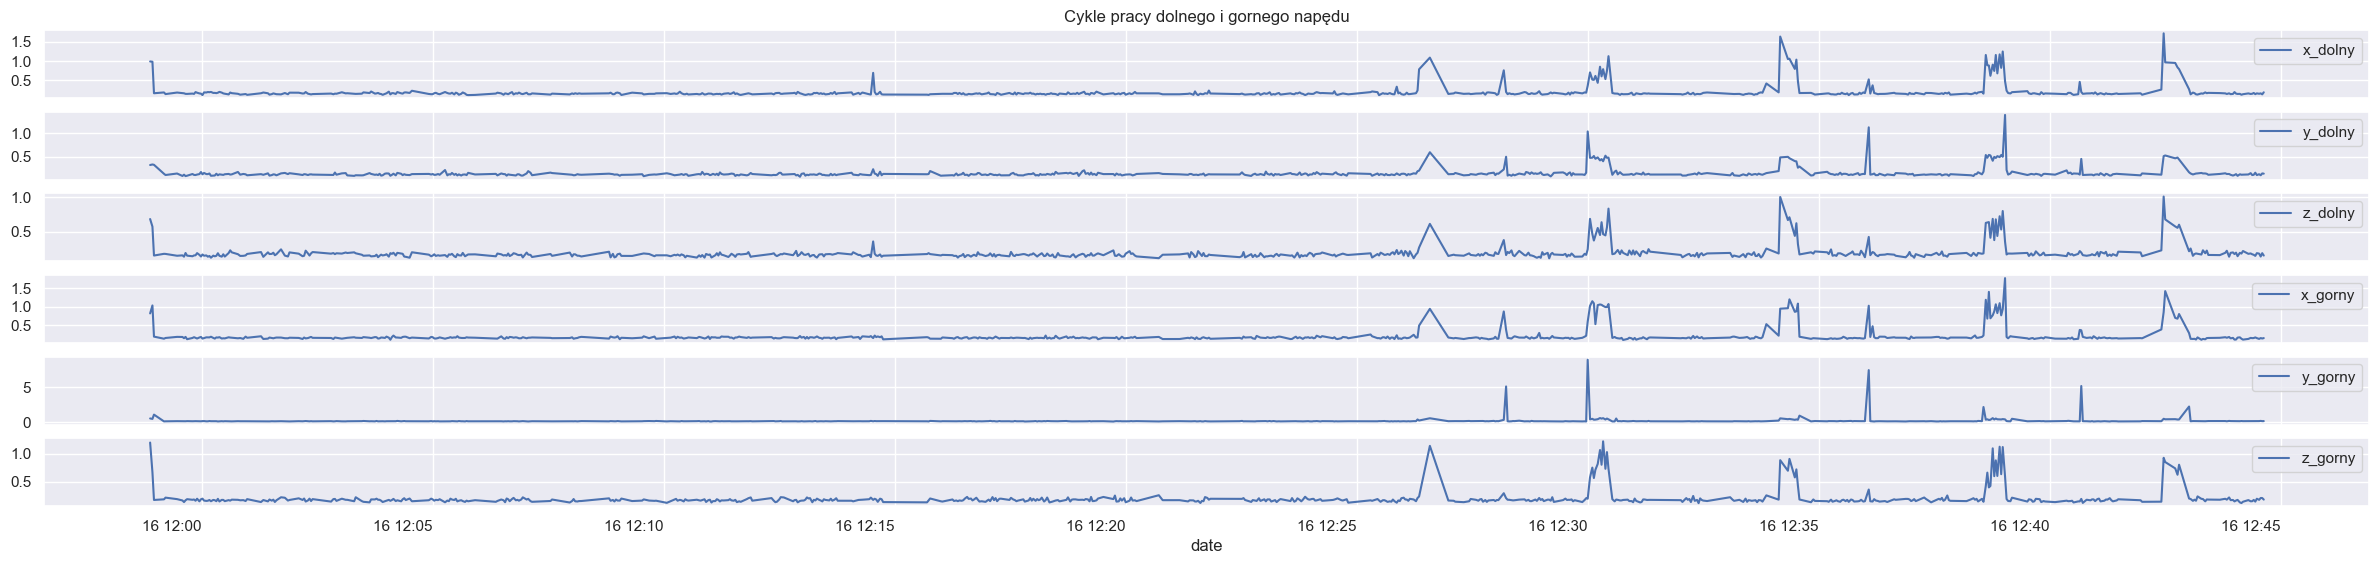

In [106]:
fig, axes = plt.subplots(6,1, figsize=(30,7), dpi=100)
merged_data=pd.merge(df_dolny_naped,df_gorny_naped,how='inner',on='date')

merged_data.plot(title='Cykle pracy dolnego i gornego napędu', legend=True, ax=axes[0],use_index=True,x='date',y='x_dolny')
merged_data.plot(legend=True, ax=axes[1],use_index=True,x='date',y='y_dolny')
merged_data.plot( legend=True, ax=axes[2],use_index=True,x='date',y='z_dolny')
merged_data.plot(legend=True, ax=axes[3],use_index=True,x='date',y='x_gorny')
merged_data.plot( legend=True, ax=axes[4],use_index=True,x='date',y='y_gorny')
merged_data.plot(legend=True, ax=axes[5],use_index=True,x='date',y='z_gorny')


fig.autofmt_xdate(bottom=0.2, rotation=0, ha='right')

In [6]:
df

x_dolny  y_dolny  z_dolny  x_gorny  y_gorny  z_gorny
date                                                                     
2021-11-16 11:58:53  0.98979  0.32636  0.68453  0.81762  0.53189  1.20107
2021-11-16 11:58:56  0.98216  0.33767  0.57393  1.03256  0.46878  0.66836
2021-11-16 11:58:58  0.16378  0.33049  0.15301  0.19077  1.08558  0.17187
2021-11-16 11:59:11  0.18482  0.13925  0.17802  0.13479  0.10800  0.18312
2021-11-16 11:59:13  0.14198  0.11358  0.17663  0.15433  0.11897  0.21355
...                      ...      ...      ...      ...      ...      ...
2021-11-16 12:44:29  0.16068  0.11257  0.18778  0.15076  0.14827  0.19366
2021-11-16 12:44:32  0.15044  0.13004  0.18119  0.12946  0.15136  0.17406
2021-11-16 12:44:34  0.16100  0.10871  0.13841  0.15151  0.17844  0.20704
2021-11-16 12:44:36  0.13478  0.14675  0.18775  0.14055  0.14561  0.20654
2021-11-16 12:44:38  0.18817  0.14246  0.15284  0.15114  0.15264  0.17849

[703 rows x 6 columns]

In time series analysis, it is important that the data is stationary and have no autocorrelation. Stationarity refers to the behavior where the mean and standard deviation of the data changes over time, the data with such behavior is considered not stationary. On the other hand, autocorrelation refers to the behavior of the data where the data is correlated with itself in a different time period.

Next, we will visually inspect the stationarity of each feature in the data set and the following code will do just that. Later, we will also perform the Dickey Fuller test to quantitatively verify the observed stationarity. In addition, we will inspect the autocorrelation of the features before feeding them into the clustering algorithms to detect anomalies.

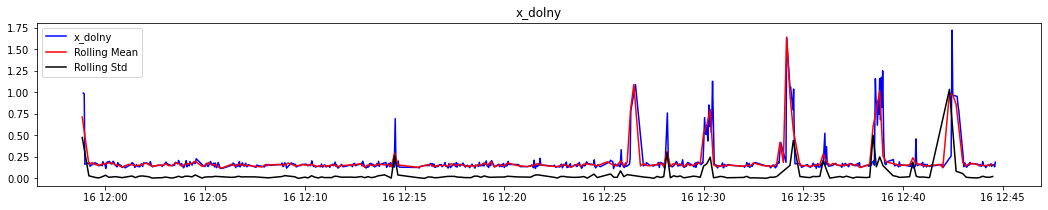

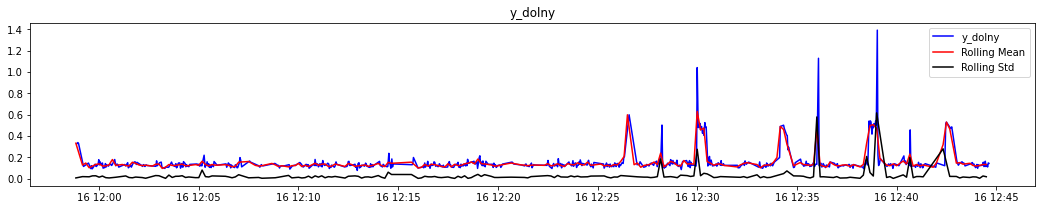

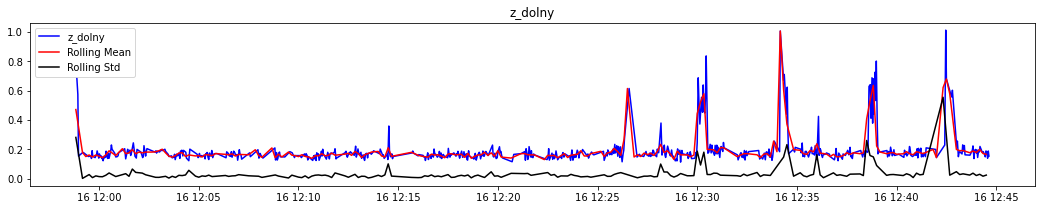

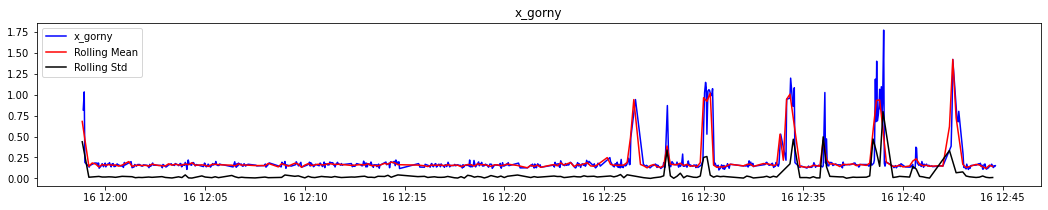

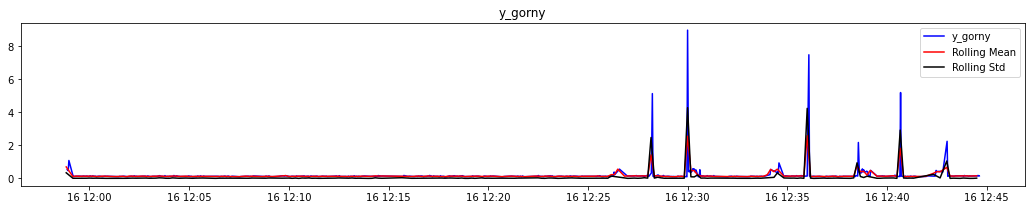

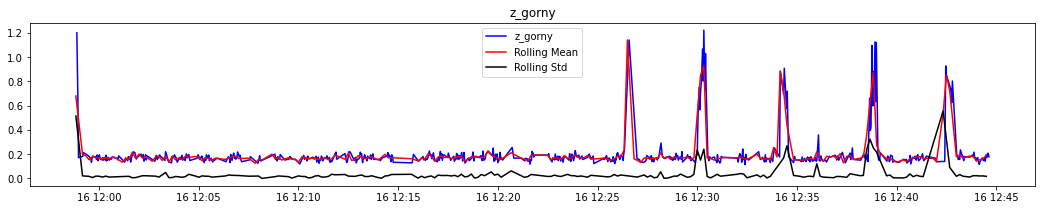

In [13]:
# Resample the entire dataset by 10 second averaging
rollmean = input.resample(rule='10S').mean().dropna()
rollstd = input.resample(rule='10S').std().dropna()

# Plot time series for each sensor and component with its mean and standard deviation
for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(X[name], color='blue', label=name)
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

Data actually looks pretty stationary where the rolling mean and standard deviation don’t seem to change over time except during the short periods (high amplitude peaks). This is the case for all of the components in this data set but it may not always be the case in which situations various transformation methods must be applied to make the data stationary before training the data.

It is pretty redundant to train models with all of the 6 sensors/components and it is not efficient. Therefore, I will employ Principal Component Analysis (PCA) technique to extract new features to be used for the modeling. In order to properly apply PCA, the data must be scaled and standardized. This is because PCA and most of the learning algorithms are distance based algorithms.

If noticed from the above plots, the magnitude of the values from each component is not consistent. Some are very small while some others are really large values. I will perform the following steps using the Pipeline library.

In [8]:
#Resetting index column just to ease the further processing
df.reset_index(drop=True, inplace=True)
df

x_dolny  y_dolny  z_dolny  x_gorny  y_gorny  z_gorny
0    0.98979  0.32636  0.68453  0.81762  0.53189  1.20107
1    0.98216  0.33767  0.57393  1.03256  0.46878  0.66836
2    0.16378  0.33049  0.15301  0.19077  1.08558  0.17187
3    0.18482  0.13925  0.17802  0.13479  0.10800  0.18312
4    0.14198  0.11358  0.17663  0.15433  0.11897  0.21355
..       ...      ...      ...      ...      ...      ...
698  0.16068  0.11257  0.18778  0.15076  0.14827  0.19366
699  0.15044  0.13004  0.18119  0.12946  0.15136  0.17406
700  0.16100  0.10871  0.13841  0.15151  0.17844  0.20704
701  0.13478  0.14675  0.18775  0.14055  0.14561  0.20654
702  0.18817  0.14246  0.15284  0.15114  0.15264  0.17849

[703 rows x 6 columns]

## Libraries for PCA

In [16]:
# Standardize/scale the dataset and apply PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

### For the PCA analysis we first scale the data (preprocess) then we measure how much components are meaningful in terms of explaining the variance of our data

In [36]:
# Extract the names of the numerical columns and scale the data
input=pd.merge(df_dolny_naped,df_gorny_naped,how='inner',on='date')
df=input

df.set_index('date', inplace=True)

df2 = df
names=df2.columns
x = df[names]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

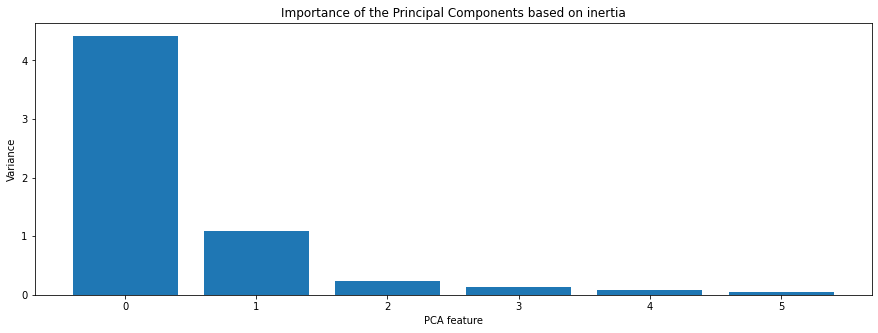

In [37]:
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

Another approach to select PCA (just to compare, see different visualization)

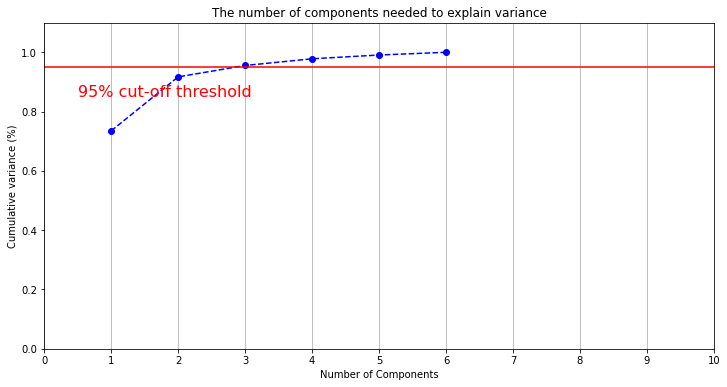

In [38]:
scaled_data = scaler.fit_transform(df)
pca = PCA().fit(scaled_data)


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 7, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In this case again, to get 95% of variance explained we need 2 principal components.


### It appears that the first two principal components are the most important as per the features extracted by the PCA in both of the above importance plots. So as the next step, I will perform PCA with 2 components which will be features to be used in the training of the models.

In [39]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

Now, I will check the stationarity and autocorrelation of these two principal components just to be sure they are stationary and not autocorrelated.
So we want to use the PCA representation instead of originally measured components.

In [40]:
from statsmodels.tsa.stattools import adfuller
# Run Augmented Dickey Fuller Test
result = adfuller(principalDf['pc1'])
# Print p-value
print(result[1])
result = adfuller(principalDf['pc2'])
# Print p-value
print(result[1])

1.195995033816763e-29
5.199174920099246e-12


Running the Dickey Fuller test on the 1st and 2nd principal components, give p-values which are both very small numbers (much smaller than 0.05). Thus, we will reject the Null Hypothesis and say the data is stationary.

I will use the ACF to quickly visually verify that there is no autocorrelation.

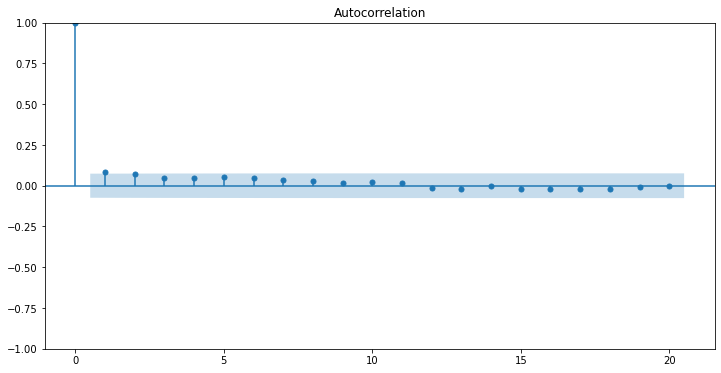

In [41]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(principalDf['pc1'].dropna(), lags=20, alpha=0.05);

Can say that data is not autocorrelated (i.e. indication of stationarity) beacuse the values very quickly drop below the significance level denoted with transparent bar

## Anomaly detection on the previously identified most important PCA components

#### Initial approach using Interquartile Range (later we can test much more solutions, bus what's important that data shows potential
#### for more advanced automatic picking, and anomaly detection

The used approach is as follows:
1. Calculate IQR which is the difference between 75th (Q3)and 25th (Q1) percentiles.
2. Calculate upper and lower bounds for the outlier.
3. Filter the data points that fall outside the upper and lower bounds and flag them as outliers.
4. Finally, plot the outliers on top of the time series data (the readings from sensor_11 in this case)

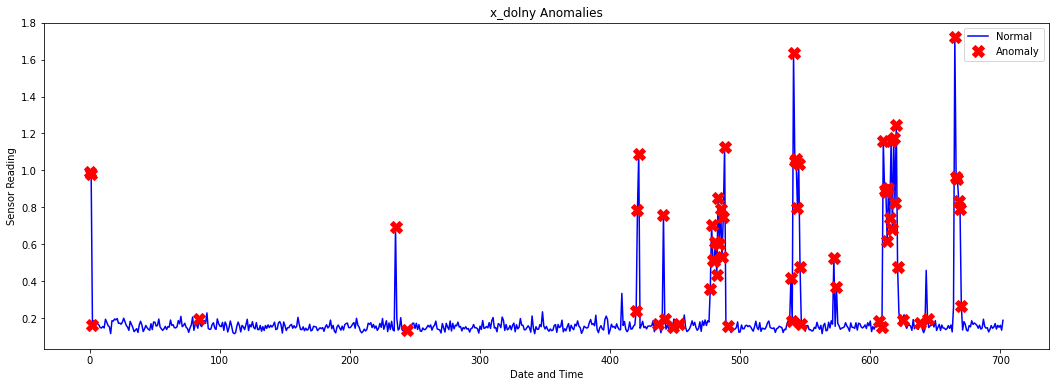

In [44]:
df['pc1']=principalDf['pc1']
df['pc2']=principalDf['pc2']

# Calculate IQR for the 1st principal component (pc1)
q1_pc1, q3_pc1 = df['pc1'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
# Calculate upper and lower bounds for outlier for pc1
lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
# Filter out the outliers from the pc1
df['anomaly_pc1'] = ((df['pc1']>upper_pc1) | (df['pc1']<lower_pc1)).astype('int')
# Calculate IQR for the 2nd principal component (pc2)
q1_pc2, q3_pc2 = df['pc2'].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2
# Calculate upper and lower bounds for outlier for pc2
lower_pc2 = q1_pc2 - (1.5*iqr_pc2)
upper_pc2 = q3_pc2 + (1.5*iqr_pc2)
# Filter out the outliers from the pc2
df['anomaly_pc2'] = ((df['pc2']>upper_pc2) | (df['pc2']<lower_pc2)).astype('int')
# Let's plot the outliers from pc1 on top of the x_dolny and see where they occured in the time series
a = df[df['anomaly_pc1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['x_dolny'], color='blue', label='Normal')
_ = plt.plot(a['x_dolny'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('x_dolny Anomalies')
_ = plt.legend(loc='best')
plt.show();

In [ ]:
# Anomalies projected on all components

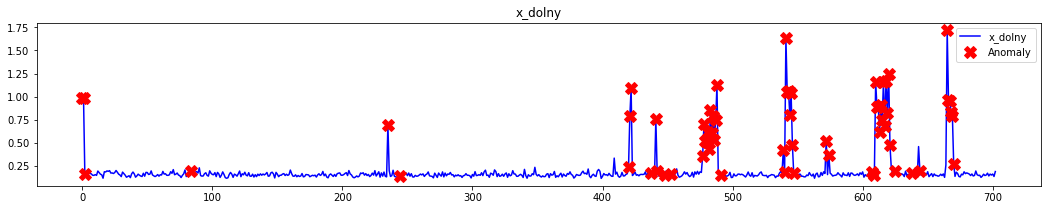

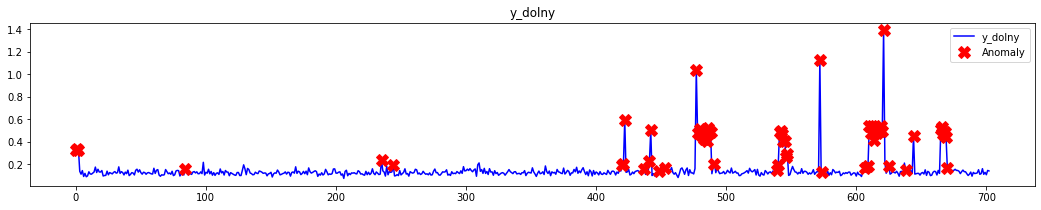

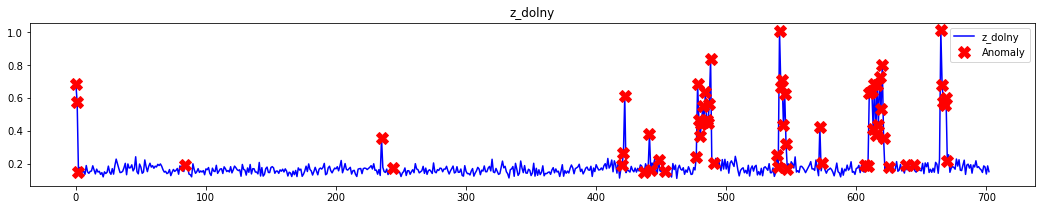

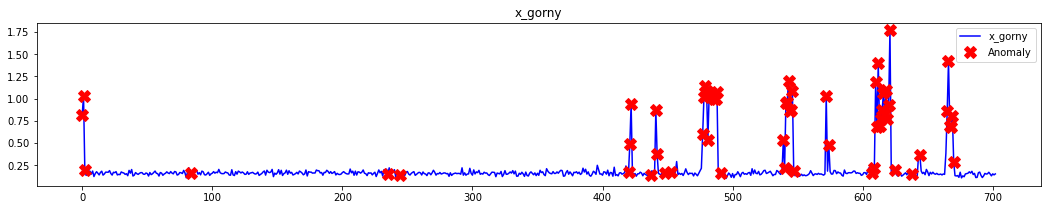

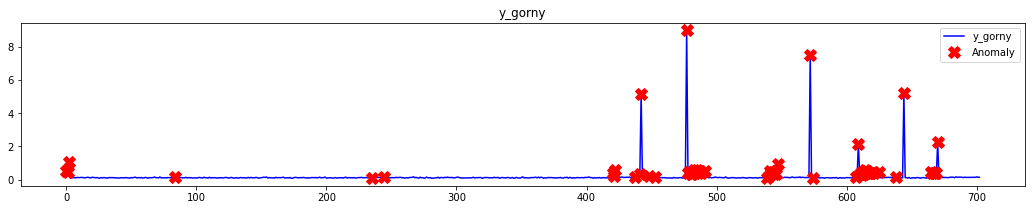

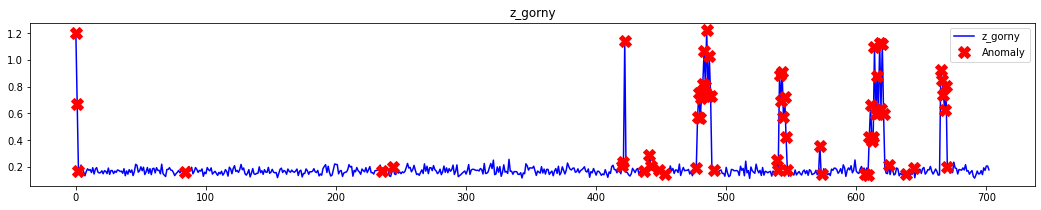

In [46]:
for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(X[name], color='blue', label=name)
    _ = plt.plot(a[name], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

As seen above, the anomalies are consistent with most of the "high-amplitude" peaks regardless of measured component. This could be a very valuable information for Customer to see and be able to shut down / change sth in production just before the end od descending slope of picked values. Later we can test if we detect similar pattern in anomalies from the next two algorithms.

### Further data exploration. Specifically using tSNE embedding and K-means clustering for the purpose of indentifying the possibility to automatically distinguish between various states of the production processes

# Clustering

## Libraries

In [47]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

Once more loading Winkelmann data and preparing dataframes

In [82]:
#Read sensor data from dolne wrzeciono
df_dolny_naped = pd.read_csv('w dolne 11.58.csv',  sep=';', engine='python',parse_dates=['Category'])
df_dolny_naped.head()

#Read sensor data from gorne wrzeciono
df_gorny_naped = pd.read_csv('w gorne 11.58.csv',  sep=';', engine='python',parse_dates=['Category'])
df_gorny_naped

#Renaming columns
df_dolny_naped.columns=['date','x_dolny','y_dolny','z_dolny']
df_dolny_naped['date']=pd.to_datetime(df_dolny_naped.date)
df_gorny_naped.columns=['date','x_gorny','y_gorny','z_gorny']
df_gorny_naped['date']=pd.to_datetime(df_gorny_naped.date)

#Merging data from wrzeciono gorne and wrzeciono dolne such that both measurments are time aligned
input=pd.merge(df_dolny_naped,df_gorny_naped,how='inner',on='date')



X=input
X.drop(['date'], axis=1, inplace=True)

In [83]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(X.shape[0])

Once again: PCA is a technique for reducing the number of dimensions in a dataset whilst retaining most information. It is using the correlation between some dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed

Generate, from the original 6 dimensions (2 sensors x 3 components per sensor), the first three principal components. And we’ll also see how much of the variation in the total dataset they actually account for.

In [84]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X.values)
X['pca-one'] = pca_result[:,0]
X['pca-two'] = pca_result[:,1]
X['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.73505893 0.23619687 0.01491996]


Consistently with previous results, the two PCA components explain most of the data.

We create now a scatterplot of the first and second principal component and color each of the different types of digits with a different color. Similar states of production (very optimsitic assumption) should be positioned (i.e., clustered) together in groups, which would mean that the first two principal components actually tell us a great sth about the specific types of digits.

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

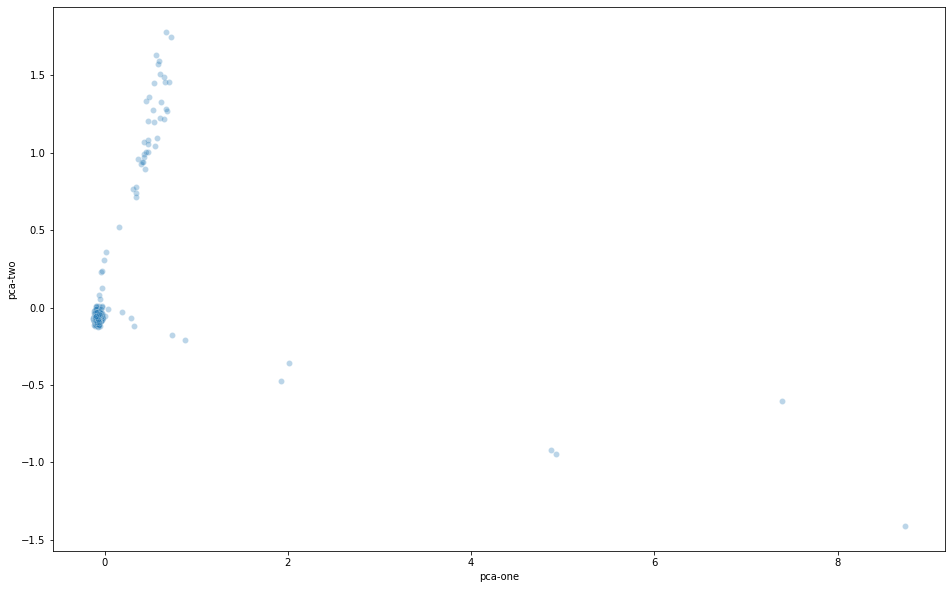

In [85]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",

    palette=sns.color_palette("hls", 10),
    data=X.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

For a 3d-version of the same plot (i.e. just to see how 3 PCA components look like) - basically more components give possibility for more detailed/advanced analysis

C:\Users\Michal\AppData\Local\Temp/ipykernel_12584/3298400172.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


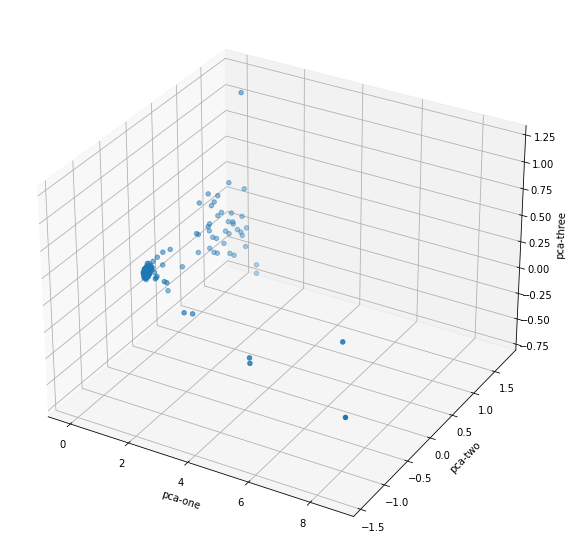

In [68]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=X.loc[rndperm,:]["pca-one"],
    ys=X.loc[rndperm,:]["pca-two"],
    zs=X.loc[rndperm,:]["pca-three"],

    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

From the graph we can see the two components definitely hold some information, maybe for different production processes or type of wrzeciono, but clearly we can not know this at the moment.

We test now another technique that we can use to reduce the number of dimensions that may prove more related to WeSense data.

### t-SNE (t-Distributed Stochastic Neighbouring Entities)

t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding”.

We look at the original data that is entered into the algorithm and investigate how to best represent this data using less dimensions by matching both distributions.

In [86]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\Michal\.conda\envs\CogniPy\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Michal\.conda\envs\CogniPy\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 703 samples in 0.000s...
[t-SNE] Computed neighbors for 703 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 703 / 703
[t-SNE] Mean sigma: 0.023159
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.216129
[t-SNE] KL divergence after 300 iterations: 1.334052
t-SNE done! Time elapsed: 4.768578290939331 seconds


Result for the two components from t-SNE

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

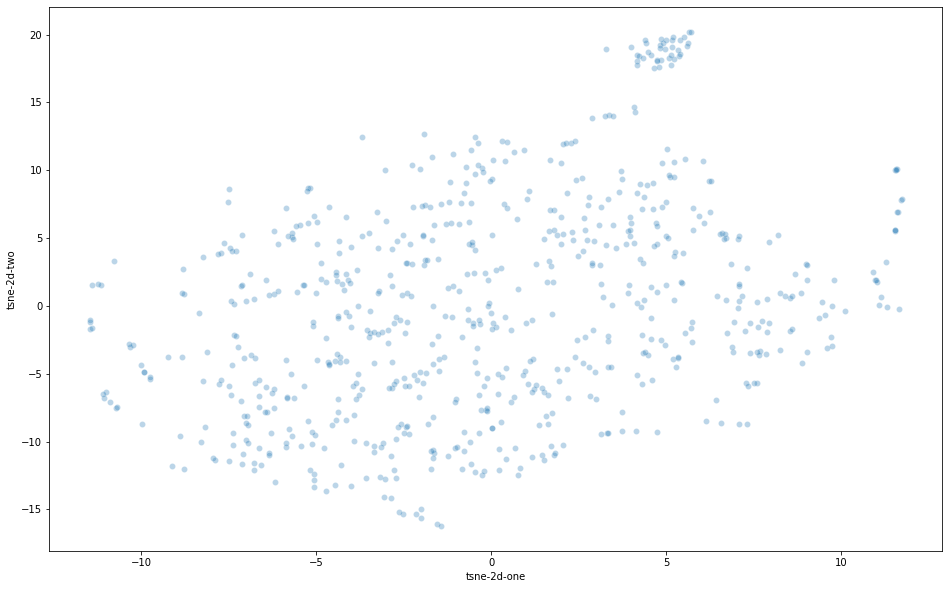

In [87]:
X['tsne-2d-one'] = tsne_results[:,0]
X['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",

    palette=sns.color_palette("hls", 10),
    data=X,
    legend="full",
    alpha=0.3
)


For better results we can try applying t-SNE embedding on the PCA results instead of raw measured data

t-SNE using data from PCA, not the original input

In [88]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\Michal\.conda\envs\CogniPy\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Michal\.conda\envs\CogniPy\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 4.058881998062134 seconds


<AxesSubplot:xlabel='tsne-pca-one', ylabel='tsne-pca-two'>

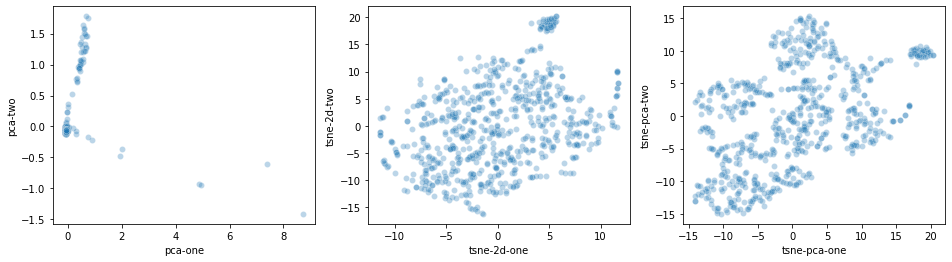

In [89]:
X['tsne-pca-one'] = tsne_pca_results[:,0]
X['tsne-pca-two'] = tsne_pca_results[:,1]


plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",

    palette=sns.color_palette("hls", 10),
    data=X,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",

    palette=sns.color_palette("hls", 10),
    data=X,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca-one", y="tsne-pca-two",

    palette=sns.color_palette("hls", 10),
    data=X,
    legend="full",
    alpha=0.3,
    ax=ax3
)

Rightmost plot is already a significant improvement over the PCA visualisation we used earlier. We can see that the measurements are more clearly clustered in their own sub groups. If we would now use a clustering algorithm to pick out the separate clusters we could probably quite accurately assign new points to a label.

Plot on the right, after some improvements, might eventually tell us how does the different state of 'production' process are represented in terms of similar parametrization. I see there 7 clusters:)

In [90]:
# Initial guess on clusters based on visual inspection of the rightmost result (tSNE applied on PCA)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7)
kmeans.fit(tsne_pca_results)

X['Class']=kmeans.labels_

<AxesSubplot:xlabel='tsne-pca-one', ylabel='tsne-pca-two'>

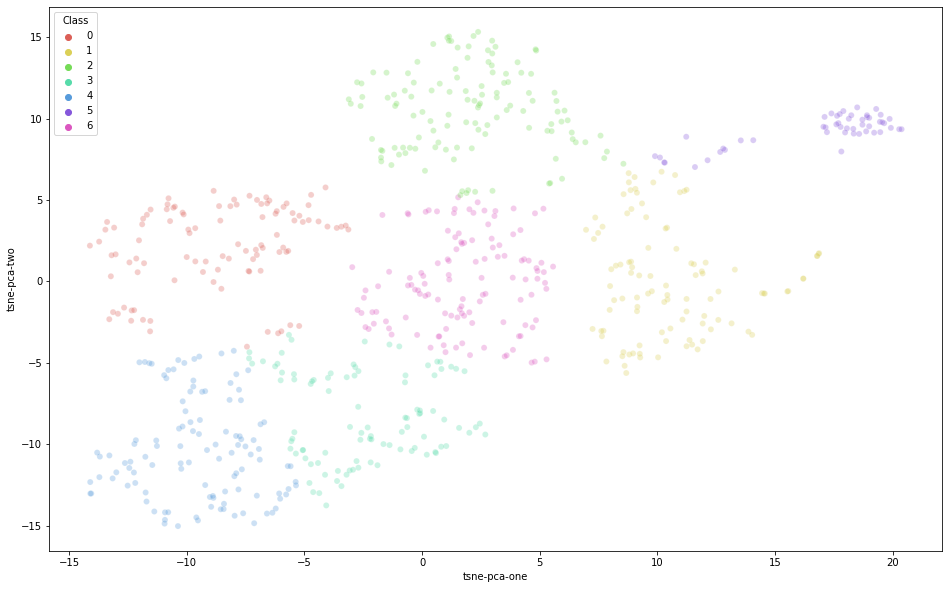

In [91]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-pca-one", y="tsne-pca-two",
    hue="Class",
    palette=sns.color_palette("hls", 7),
    data=X,
    legend="full",
    alpha=0.3
)

Color time seris x dolny, based on the above results, to see if we really can disitiugish different processes

Next, apply any of the anomaly detection processes and compare the results

CLUSTER COLOR OVERLAY ON 1D TIME SERIES DATA (to be improved / conceptualized)

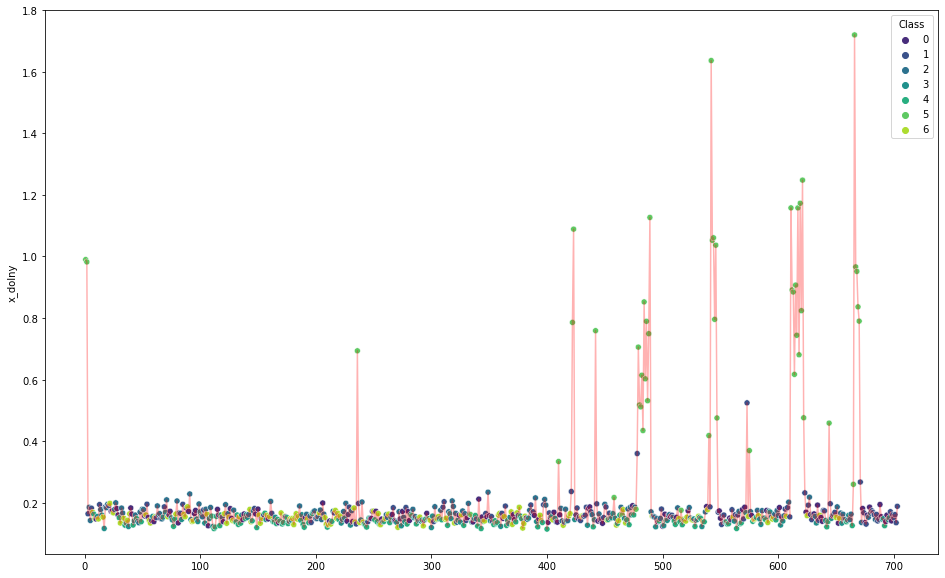

In [92]:
plt.figure(figsize=(16,10))
plt.plot(list(range(1, 704)), X['x_dolny'], color='r',alpha=0.3)


sns.scatterplot(
    x=list(range(1, 704)),
    y="x_dolny",
    hue="Class",
    palette=sns.color_palette("viridis", 7),
    data=X,
    legend="full",
    alpha=1
)
plt.show()



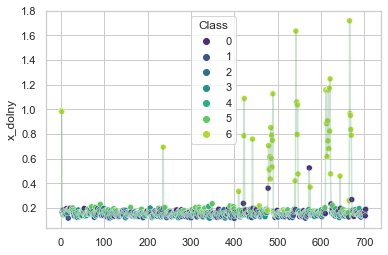

In [81]:
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.lineplot(data=X, x=list(range(1, 704)), y='x_dolny', color='g', alpha=0.3,ax=ax)
p2 = sns.scatterplot(
    x=list(range(1, 704)),
    y="x_dolny",
    hue="Class",
    palette=sns.color_palette("viridis", 7),
    data=X,
    legend="full",
    alpha=1
)


Exemplary juxtaposition of difference between data from gorne and dolne wrzeciono

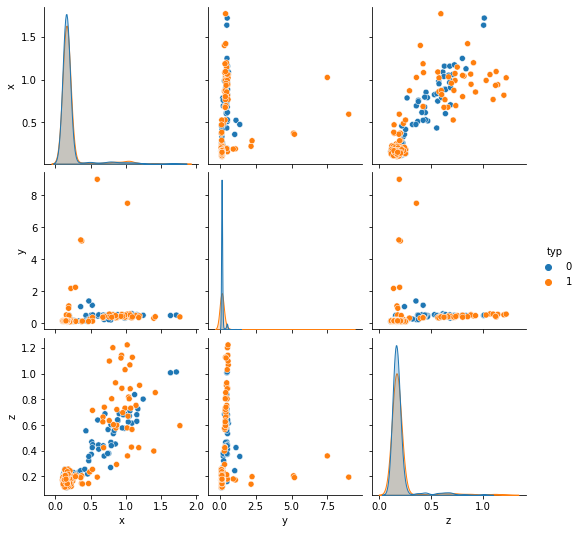

In [102]:
#sns.pairplot(merged_data)
df_dolny_naped_2 = pd.read_csv('w dolne 11.58.csv',  sep=';', engine='python',parse_dates=['Category'])
df_gorny_naped_2 = pd.read_csv('w gorne 11.58.csv',  sep=';', engine='python',parse_dates=['Category'])
df_dolny_naped_2.columns=['date','x','y','z']
df_dolny_naped_2['date']=pd.to_datetime(df_dolny_naped.date)
df_dolny_naped_2['typ'] = 0
df_gorny_naped_2.columns=['date','x','y','z']
df_gorny_naped_2['date']=pd.to_datetime(df_gorny_naped.date)
df_gorny_naped_2['typ'] = 1
df_all=[df_dolny_naped_2,df_gorny_naped_2]
merged_data_2=pd.merge(df_dolny_naped_2,df_gorny_naped_2,how='inner',on='date')
#sns.pairplot(merged_data_2, hue="typ", diag_kind="hist")
bigdata = df_dolny_naped_2.append(df_gorny_naped_2, ignore_index=True)
a=bigdata['date'][bigdata['date'].duplicated()].unique()
#bigdata
a.shape
merged_df = bigdata[bigdata['date'].isin(a)]


sns.pairplot(merged_df, hue="typ")

<AxesSubplot:xlabel='date', ylabel='x'>

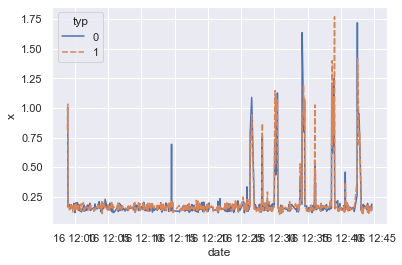

In [103]:
import seaborn as sns
#sns.set_theme(style="ticks")

sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x="date", y="x",
             hue="typ", style="typ",
             data=merged_df)